# Twitter Sentiment Analysis

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [53]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GlobalMaxPooling1D
from tensorflow.keras.layers import Dense,Flatten,Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Hashing
from tensorflow.keras.preprocessing.text import hashing_trick
from tensorflow.keras.preprocessing.text import Tokenizer

from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# nltk.download('stopwords')

In [4]:
# DATASET
TRAIN_SIZE = 0.8

# TEXT CLENAING

# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 40
EPOCHS = 6
BATCH_SIZE = 128


In [6]:
df=pd.read_csv(r'D:\Data/sentiment_cleaned_data.csv',encoding='latin-1')
df=df.drop(columns=['Unnamed: 0','length'])

In [7]:
print("Dataset size:", len(df))

Dataset size: 1599505


In [8]:
df.head(5)

,target,transformed_tweet
0,0,switchfoot http twitpic com zl awww bummer sho...
1,0,upset updat facebook text might cri result sch...
2,0,kenichan dive mani time ball manag save rest g...
3,0,whole bodi feel itchi like fire
4,0,nationwideclass behav mad see


Text(0.5, 1.0, 'Dataset labels distribuition')

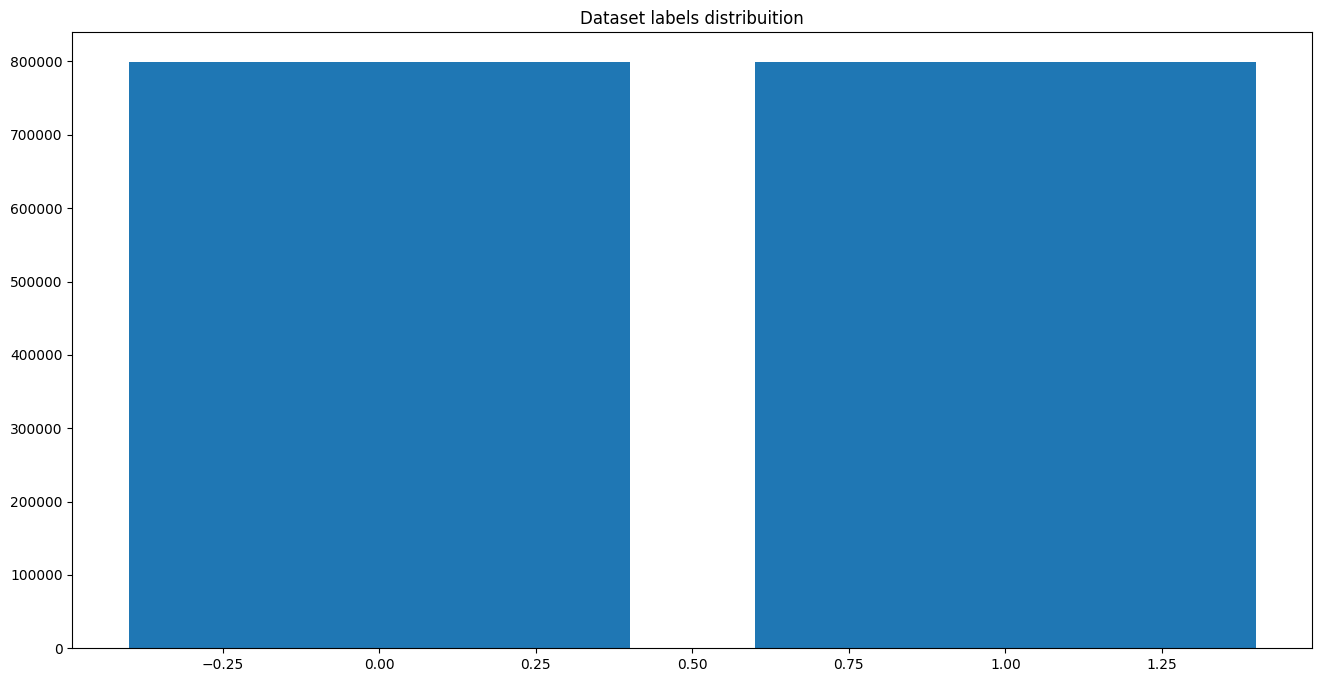

In [11]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

### Split train and test

In [12]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1279604
TEST size: 319901


### Word2Vec 

In [13]:
df_train

,target,transformed_tweet
218151,0,anyon answer tweet send grrrrr
1589632,1,sleep shop lol http twitpic com jch
837050,1,akibafilm thank
1572461,1,kid school summer still busier expect good tho...
1211354,1,night owl hungri night owl wendi anyon
...,...,...
259178,0,last fm est offlin
1414414,1,friendster kinda bore myspac awesom
131932,0,say aww last week na ng sepm http plurk com p ...
671155,0,oh fight


In [14]:
documents = [_text.split() for _text in df_train['transformed_tweet']]


In [15]:
from gensim.models import Word2Vec


In [16]:
w2v_model = Word2Vec(sentences=documents, vector_size=100, window=7, min_count=10, workers=4)
# model.save("word2vec.model")

2023-08-09 18:37:39,592 : INFO : collecting all words and their counts
2023-08-09 18:37:39,594 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-08-09 18:37:39,612 : INFO : PROGRESS: at sentence #10000, processed 77516 words, keeping 15132 word types
2023-08-09 18:37:39,631 : INFO : PROGRESS: at sentence #20000, processed 155196 words, keeping 24727 word types
2023-08-09 18:37:39,651 : INFO : PROGRESS: at sentence #30000, processed 232175 words, keeping 32877 word types
2023-08-09 18:37:39,669 : INFO : PROGRESS: at sentence #40000, processed 309612 words, keeping 40398 word types
2023-08-09 18:37:39,693 : INFO : PROGRESS: at sentence #50000, processed 386356 words, keeping 47342 word types
2023-08-09 18:37:39,711 : INFO : PROGRESS: at sentence #60000, processed 463425 words, keeping 53984 word types
2023-08-09 18:37:39,727 : INFO : PROGRESS: at sentence #70000, processed 540720 words, keeping 60121 word types
2023-08-09 18:37:39,744 : INFO : PROGRESS: at s

In [21]:
words = w2v_model.wv.index_to_key  # Get the list of words in the vocabulary
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 29829


In [17]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-08-09 18:38:09,077 : WARNING : Effective 'alpha' higher than previous training cycles
2023-08-09 18:38:09,078 : INFO : Word2Vec lifecycle event {'msg': 'training model with 4 workers on 29829 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2023-08-09T18:38:09.078084', 'gensim': '4.3.1', 'python': '3.10.12 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 19:01:18) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'train'}
2023-08-09 18:38:10,092 : INFO : EPOCH 0 - PROGRESS: at 14.36% examples, 1203110 words/s, in_qsize 7, out_qsize 0
2023-08-09 18:38:11,094 : INFO : EPOCH 0 - PROGRESS: at 29.21% examples, 1223472 words/s, in_qsize 7, out_qsize 0
2023-08-09 18:38:12,099 : INFO : EPOCH 0 - PROGRESS: at 46.79% examples, 1305443 words/s, in_qsize 7, out_qsize 0
2023-08-09 18:38:13,114 : INFO : EPOCH 0 - PROGRESS: at 63.84% examples, 1332283 words/s, in_qsize 7, out_qsize 1
2023-08-09 18:38:

CPU times: total: 1min 42s
Wall time: 3min 14s


(268719048, 316655168)

In [34]:
w2v_model.save(WORD2VEC_MODEL)

2023-08-09 18:42:29,668 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-08-09T18:42:29.668224', 'gensim': '4.3.1', 'python': '3.10.12 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 19:01:18) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'saving'}
2023-08-09 18:42:29,680 : INFO : not storing attribute cum_table
2023-08-09 18:42:29,732 : INFO : saved model.w2v


In [19]:
w2v_model.wv.most_similar("great")

[('fantast', 0.8520932197570801),
 ('good', 0.7700976729393005),
 ('fabul', 0.7648777365684509),
 ('awesom', 0.7365319132804871),
 ('amaz', 0.7003041505813599),
 ('fab', 0.695418119430542),
 ('excel', 0.6850428581237793),
 ('nice', 0.6792731881141663),
 ('wonder', 0.6546331644058228),
 ('enjoy', 0.644711971282959)]

### Tokenize Text

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['transformed_tweet'])
train_sequences = tokenizer.texts_to_sequences(df_train['transformed_tweet'])
test_sequences=tokenizer.texts_to_sequences(df_test['transformed_tweet'])

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 460853
CPU times: total: 26.2 s
Wall time: 37.2 s


In [21]:
import pickle 
# Save the Tokenizer object
with open('tokenizer_embd.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
train_sequences

[[285, 543, 71, 307, 4235],
 [48, 252, 13, 9, 81, 21, 71675],
 [162756, 14],
 [217, 78, 161, 31, 12456, 751, 4, 67, 132, 2, 118],
 [28, 3434, 467, 28, 3434, 3001, 285],
 [9349, 25, 354, 1766, 558, 3869, 154],
 [98893, 356, 7305, 5, 38, 50, 267, 4333],
 [162757,
  18,
  316,
  825,
  2931,
  270,
  201,
  409,
  22,
  236,
  426,
  54,
  5,
  1768,
  197,
  310],
 [162758, 383, 148, 74, 695],
 [113, 25, 319, 14, 1269],
 [2013, 65, 13549, 341, 849, 11, 3839, 715],
 [7763, 739, 236, 2362, 7081, 79, 5, 630, 441, 3, 2006],
 [162759, 3544, 337, 573, 40, 70, 17, 15446, 998, 9, 81, 21, 162760],
 [2453, 3, 27, 73, 100, 7, 100, 3, 6, 32, 125, 732, 594],
 [162761, 672, 2434, 34, 152, 4639, 12457, 57, 32, 46, 98894],
 [12, 19, 62, 146, 577, 906, 4488, 3886],
 [178, 182, 935],
 [1190, 7627, 7353, 568, 156, 37, 40],
 [18, 926, 588, 378, 84, 4819, 1658, 109],
 [2097,
  76,
  356,
  1761,
  10260,
  9,
  66,
  141,
  121,
  3870,
  2862,
  20,
  152,
  1051,
  464,
  723,
  2013],
 [3287, 130, 945, 37

In [23]:
%%time
x_train = pad_sequences(train_sequences, maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(test_sequences, maxlen=SEQUENCE_LENGTH)

CPU times: total: 2.09 s
Wall time: 3.95 s


In [24]:
x_train[0].shape

(40,)

In [26]:
y_train=df_train.target.values.reshape(-1,1)
y_test=df_test.target.values.reshape(-1,1)

In [27]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1279604, 40)
y_train (1279604, 1)

x_test (319901, 40)
y_test (319901, 1)


### Embedding layer

In [28]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(460853, 100)


In [29]:
x_train.shape

(1279604, 40)

In [30]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [31]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.summary()

2023-08-09 18:42:07,127 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           46085300  
                                                                 
 dropout (Dropout)           (None, 40, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 46,165,801
Trainable params: 80,501
Non-trainable params: 46,085,300
_________________________________________________________________


### Compile model

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [33]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [35]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=EPOCHS,
                    validation_split=0.25,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/6
7498/7498 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.7571WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-08-09 19:19:02,117 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


7498/7498 [==============================] - 2151s 286ms/step - loss: 0.4950 - accuracy: 0.7571 - val_loss: 0.4665 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 2/6
7498/7498 [==============================] - ETA: 0s - loss: 0.4788 - accuracy: 0.7677WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-08-09 19:53:16,949 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


7498/7498 [==============================] - 2055s 274ms/step - loss: 0.4788 - accuracy: 0.7677 - val_loss: 0.4587 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 3/6
7498/7498 [==============================] - ETA: 0s - loss: 0.4749 - accuracy: 0.7701WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-08-09 20:27:06,704 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


7498/7498 [==============================] - 2030s 271ms/step - loss: 0.4749 - accuracy: 0.7701 - val_loss: 0.4566 - val_accuracy: 0.7828 - lr: 0.0010
Epoch 4/6
7498/7498 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.7719WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-08-09 21:35:32,818 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


7498/7498 [==============================] - 4106s 548ms/step - loss: 0.4725 - accuracy: 0.7719 - val_loss: 0.4541 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 5/6
7498/7498 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.7725WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-08-09 22:10:52,925 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


7498/7498 [==============================] - 2120s 283ms/step - loss: 0.4713 - accuracy: 0.7725 - val_loss: 0.4522 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 6/6
7498/7498 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.7735WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-08-09 22:50:22,678 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


7498/7498 [==============================] - 2370s 316ms/step - loss: 0.4704 - accuracy: 0.7735 - val_loss: 0.4532 - val_accuracy: 0.7840 - lr: 0.0010
CPU times: total: 1h 8min 58s
Wall time: 4h 7min 12s


In [36]:
model.save('lstm_saved_embd')

INFO:tensorflow:Assets written to: lstm_saved_embd\assets


2023-08-09 22:50:28,286 : INFO : Assets written to: lstm_saved_embd\assets


In [37]:
loaded_model = tf.keras.models.load_model('lstm_saved_embd')

2023-08-09 22:50:28,578 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


### Evaluate

In [38]:
y_pred=loaded_model.predict(x_test)
y_pred=(y_pred > 0.5).astype("int64").reshape(-1)

9997/9997 [==============================] - 320s 32ms/step


In [43]:
from sklearn import metrics

def model_report(y_test,y_pred):
    print(f'----Confusion matrix---- \n \n{metrics.confusion_matrix(y_test,y_pred)}\n')
    print(f'Acccuracy Score : {metrics.accuracy_score(y_test,y_pred)}\n')
    print(metrics.classification_report(y_test,y_pred))

y_test=df_test['target']
model_report(y_test,y_pred)

----Confusion matrix---- 
 
[[120181  39192]
 [ 30337 130191]]

Acccuracy Score : 0.7826546337773249

              precision    recall  f1-score   support

           0       0.80      0.75      0.78    159373
           1       0.77      0.81      0.79    160528

    accuracy                           0.78    319901
   macro avg       0.78      0.78      0.78    319901
weighted avg       0.78      0.78      0.78    319901



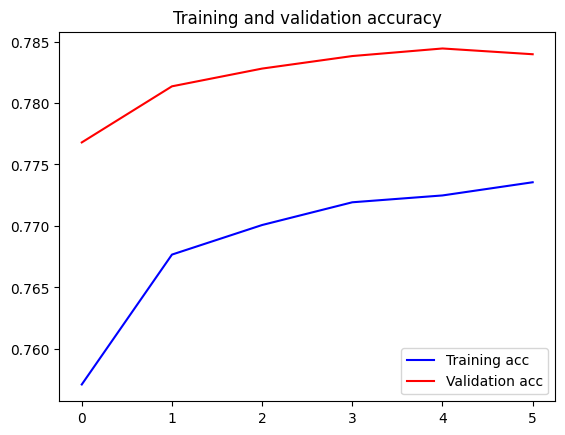

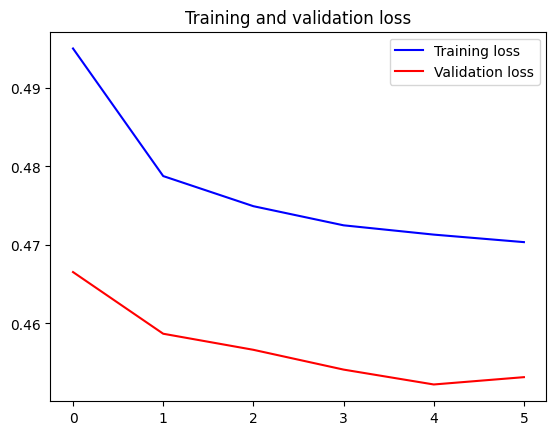

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [48]:
def cleaning(tweet):
    tweet=re.sub(r'[^a-zA-Z]',' ',tweet)
    tweet=tweet.lower()
    tweet=tweet.split()
    ps=PorterStemmer()
    tweet=[ps.stem(word) for word in tweet if word not in stopwords.words("english")]
    tweet=' '.join(tweet)
    return tweet

In [2]:
def decode_sentiment(score):
    if score>0.5:
        return 'POSITIVE'
    else:
         return 'NEGATIVE'

In [70]:
def predict(text, include_neutral=True):
    # Tokenize text
    text=cleaning(text)
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH,padding='pre')
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = 'Positive' if prediction > 0.5 else 'Negative'
  
    return {"label": label, "score": float(score[0]),
      }  

In [71]:
tweet='''
Average. Cold coffee not so good and biryani tastes like garbage.
'''
predict(tweet)

1/1 [==============================] - 0s 57ms/step


{'label': 'NEGATIVE', 'score': 0.33264580368995667}

### Save model

In [ ]:
# model.save(KERAS_MODEL)
# w2v_model.save(WORD2VEC_MODEL)
# pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
# pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)